<a href="https://colab.research.google.com/github/efeecllk/investor-sentiments/blob/main/lstm_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
# Load and Preprocess Dataset

df = pd.read_csv('/content/drive/MyDrive/NLP/clean_tweet.csv')
df_label_0 = df[df['label'] == 0].sample(n=4000, random_state=42)
df_label_1 = df[df['label'] == 1].sample(n=4000, random_state=42)
df_label_2 = df[df['label'] == 2].sample(n=4000, random_state=42)

df = pd.concat([df_label_0, df_label_1, df_label_2]).reset_index(drop=True)

print(df['label'].value_counts())

# Check dataset
print(df.head())

# Preprocessing function
def preprocess_text(text):

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['clean_text'] = df['text_v'].apply(preprocess_text)

# Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['label'])  # 0: Neutral, 1: Bullish, 2: Bearish

# Train-test split
X = df['clean_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Dataset is ready for modeling!")


label
0    4000
1    4000
2    4000
Name: count, dtype: int64
                                              text_v  label
0  financial expert predict steady increase value...      0
1  coin experiencing surge trading volume today c...      0
2  blackrock announces dividend payment dividend ...      0
3  investor urged exercise caution face market fl...      0
4  financial technology fintech rapidly transform...      0
✅ Dataset is ready for modeling!


In [3]:
# Tokenization and Padding

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1

print(f"✅ Vocabulary Size: {vocab_size}")
print(f"✅ Training data shape: {X_train_pad.shape}")


✅ Vocabulary Size: 9803
✅ Training data shape: (9600, 50)


In [4]:
# Build LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train LSTM Model

history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)


Epoch 1/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 32s 120ms/step - accuracy: 0.3182 - loss: 1.1022 - val_accuracy: 0.3297 - val_loss: 1.0989
Epoch 2/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.4257 - loss: 1.0329 - val_accuracy: 0.7255 - val_loss: 0.6787
Epoch 3/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.8026 - loss: 0.5588 - val_accuracy: 0.8094 - val_loss: 0.5543
Epoch 4/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.8925 - loss: 0.3674 - val_accuracy: 0.8146 - val_loss: 0.5705
Epoch 5/5
240/240 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.9267 - loss: 0.2865 - val_accuracy: 0.8250 - val_loss: 0.5370


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8290 - loss: 0.4924
LSTM Test Accuracy: 0.83


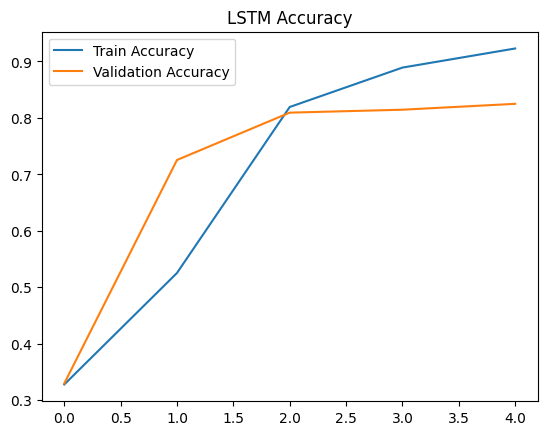

In [6]:

loss, accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f"LSTM Test Accuracy: {accuracy:.2f}")

# Plot accuracy
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()


In [7]:

lstm_model.save('/content/drive/MyDrive/NLP/lstm_model.h5')


In [8]:
# Model Performances
results = {
    'LSTM': lstm_model.evaluate(X_test_pad, y_test)[1],
}
print(results)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8290 - loss: 0.4924
{'LSTM': 0.8316666483879089}
